In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from word2vec_selection.classes import Word2VecModel
from functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adammajczyk/nltk_data..

In [2]:
save_path = 'grid_search_results_new.json'
grids_path = 'grid_search_grids.json'

In [3]:
from word2vec_selection.functions import *
model_w2v_settings = return_best_model()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
model_w2v = Word2VecModel(model_w2v_settings)

In [5]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

,title,is_clickbait,text,dataset,sample
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train
2,"[several, gop, state, move, block, funding, sa...",0,A number of GOP states have moved to introduce...,clickbait-news-detection,train
3,"[hillary, clinton, john, kerry, divergent, pat...",0,"WASHINGTON — Early in 2011, after a hectic ...",fake-news,train
4,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train


In [6]:
df['sample'].value_counts()


sample
train    66664
test      3703
val1      1852
val2      1852
Name: count, dtype: int64

In [ ]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os
import pickle

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]
df

In [8]:
df['title_vector'][0]

array([-0.35697305,  0.06077321, -0.14922297,  1.3295176 ,  0.5311293 ,
        0.31932646,  0.01412213,  0.16840689, -0.8577355 , -0.14037684,
       -0.13358489, -0.2855721 ,  0.13571858, -0.16594379,  1.3013978 ,
        0.71673936,  0.24522454, -0.29494774, -0.8973892 , -0.18755664],
      dtype=float32)

In [9]:
variables_to_drop = get_dimensions_to_drop()
variables_to_drop

[9, 19, 4, 6, 14, 12, 15, 16]

[6, 12, 9, 19, 14, 15, 16]

In [10]:
df['title_vector'] = [drop_dimensions_from_vector(vector, variables_to_drop) for vector in df['title_vector']]

In [11]:
df['title_vector'][0]

array([-0.35697305,  0.06077321, -0.14922297,  1.3295176 ,  0.31932646,
        0.16840689, -0.8577355 , -0.13358489, -0.2855721 , -0.16594379,
       -0.29494774, -0.8973892 ], dtype=float32)

In [12]:
X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])

y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import json

with open(grids_path, 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

In [37]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

# remove _grid from model names
models_to_CV = [model_name.replace('_grid', '') for model_name in models_to_CV]
models_to_CV

['decision_tree', 'catboost', 'lightgbm', 'xgboost', 'random_forest']

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [39]:
def return_model_with_param(model_name, param = dict()):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param,verbose=0)
    return model

In [40]:
models_to_CV = [
    'xgboost',
    'lightgbm', 
    'decision_tree', 
    'random_forest',  
    'catboost'
]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm

# read existing results
try:
    with open(save_path, 'r') as f:
        grid_search_results = json.load(f)
    print('Loaded existing results')
except:
    grid_search_results = dict()
    print('No existing results found - creating new dict')
for model_name in models_to_CV:
    grid_search_results[model_name] = dict()

for model_name in tqdm(models_to_CV, desc = 'Models'):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # get grid
    grid = grids[model_name+'_grid']

    # generate all combinations of parameters
    import itertools

    keys, values = zip(*grid.items())
    combinations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # do grid search
    
    for params in combinations_dicts:
        grid_search_results[model_name][str(params)] = dict()

    for params in tqdm(combinations_dicts, desc = 'Grid combinations search for model {}'.format(model_name)):
       
        model = return_model_with_param(model_name, params)
        scores_auc_cv_val = list()
        scores_auc_val2 = list()
        scores_auc_train = list()

        scores_f1_cv_val = list()
        scores_f1_val2 = list()
        scores_f1_train = list()

        for train_index, val_index in kf.split(X_train_scaled, y_train):
            X_train_kf = X_train_scaled[train_index]
            X_val_kf = X_train_scaled[val_index]
            y_train_kf = y_train.iloc[train_index]
            y_val_kf = y_train.iloc[val_index]

            model.fit(X_train_kf, y_train_kf)

            # print(model)

        
            scores_auc_cv_val.append(roc_auc_score(y_val_kf, model.predict_proba(X_val_kf)[:,1]))
            scores_auc_val2.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
            scores_auc_train.append(roc_auc_score(y_train_kf, model.predict_proba(X_train_kf)[:,1]))

            y_pred_cv_val = model.predict_proba(X_val_kf)[:,1]
            y_pred_val2 = model.predict_proba(X_test_scaled)[:,1]
            y_pred_train = model.predict_proba(X_train_kf)[:,1]

            # print(y_pred_cv_val[y_pred_cv_val>0.5])

            y_pred_cv_val = np.where(y_pred_cv_val > 0.5, 1, 0)
            y_pred_val2 = np.where(y_pred_val2 > 0.5, 1, 0)
            y_pred_train = np.where(y_pred_train > 0.5, 1, 0)


            
            scores_f1_cv_val.append(f1_score(y_val_kf, model.predict(X_val_kf)))
            scores_f1_val2.append(f1_score(y_test, model.predict(X_test_scaled)))
            scores_f1_train.append(f1_score(y_train_kf, model.predict(X_train_kf)))
            break

        # print(scores_f1_train, scores_f1_cv_val, scores_f1_val2)
        # print(scores_auc_train, scores_auc_cv_val, scores_auc_val2)

        grid_search_results[model_name][str(params)]['mean_train_f1'] = np.mean(scores_f1_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_f1'] = np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_f1'] = np.mean(scores_f1_val2)

        grid_search_results[model_name][str(params)]['mean_train_auc'] = np.mean(scores_auc_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_auc'] = np.mean(scores_auc_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_auc'] = np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['f1_diff_cv_val'] = np.mean(scores_f1_train) - np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['auc_diff_cv_val'] = np.mean(scores_auc_train) - np.mean(scores_auc_cv_val)

        grid_search_results[model_name][str(params)]['f1_diff_val2'] = np.mean(scores_f1_train) - np.mean(scores_f1_val2)
        grid_search_results[model_name][str(params)]['auc_diff_val2'] = np.mean(scores_auc_train) - np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['params'] = params

        # save results to json file
        with open(save_path, 'w') as f:
            json.dump(grid_search_results, f)
    



    print(grid_search_results[model_name])
    
# grid_search_results

In [42]:
# save results
with open(save_path, 'w') as f:
    json.dump(grid_search_results, f)

In [43]:
# load results
with open(save_path, 'r') as f:
    grid_search_results = json.load(f)

In [44]:
df_res= pd.DataFrame()

for model in grid_search_results:
    temp = grid_search_results[model]
    temp = pd.DataFrame.from_dict(temp)
    temp = temp.transpose()
    temp['model'] = model
    df_res = pd.concat([df_res, temp])

In [45]:
df_res = df_res.reset_index()

In [ ]:
top_auc = df_res[(df_res['auc_diff_val2']<=0.05)].sort_values(by='mean_val2_auc', ascending=False).head(500)
top_auc

In [ ]:
topf1 = df_res[(df_res['f1_diff_val2']<=0.05)].sort_values(by='mean_val2_f1', ascending=False).head(500)
topf1

In [48]:
top_both = pd.merge(top_auc, topf1, on=['index'], how='inner')

# keep _x columns
top_both = top_both[[col for col in top_both.columns if '_x' in col]]
top_both.columns = [col.replace('_x', '') for col in top_both.columns]

In [49]:
top_both['sum_diff_val2'] = top_both['f1_diff_val2'] + top_both['auc_diff_val2']
top_both['sum_auc_f1_val2'] = top_both['mean_val2_f1'] + top_both['mean_val2_auc']

top_both = top_both.sort_values(by='sum_auc_f1_val2', ascending=False).head(1000).reset_index(drop=True)
top_both

,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model,sum_diff_val2,sum_auc_f1_val2
0,0.800998,0.759126,0.753835,0.920308,0.888388,0.889547,0.041872,0.03192,0.047163,0.030761,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,0.077924,1.643382
1,0.796684,0.757343,0.753455,0.917751,0.886576,0.887391,0.039341,0.031174,0.04323,0.030359,"{'iterations': 500, 'learning_rate': 0.2, 'dep...",catboost,0.073589,1.640846
2,0.79643,0.757865,0.751098,0.918784,0.888542,0.889402,0.038565,0.030242,0.045332,0.029382,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,0.074714,1.6405
3,0.797353,0.754633,0.755974,0.920386,0.884944,0.884164,0.04272,0.035441,0.041379,0.036221,"{'n_estimators': 50, 'learning_rate': None, 'm...",lightgbm,0.077601,1.640138
4,0.797353,0.754633,0.755974,0.920386,0.884944,0.884164,0.04272,0.035441,0.041379,0.036221,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",lightgbm,0.077601,1.640138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.771032,0.756017,0.739706,0.899763,0.885396,0.883365,0.015015,0.014367,0.031326,0.016398,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",catboost,0.047724,1.623071
216,0.766928,0.756773,0.739483,0.895904,0.883101,0.883434,0.010155,0.012803,0.027444,0.01247,"{'iterations': 250, 'learning_rate': 0.2, 'dep...",catboost,0.039914,1.622917
217,0.786962,0.755342,0.739447,0.9118,0.885198,0.883443,0.031621,0.026603,0.047515,0.028357,"{'n_estimators': 250, 'learning_rate': None, '...",lightgbm,0.075872,1.62289
218,0.786962,0.755342,0.739447,0.9118,0.885198,0.883443,0.031621,0.026603,0.047515,0.028357,"{'n_estimators': 250, 'learning_rate': 0.1, 'm...",lightgbm,0.075872,1.62289


In [50]:
params, model_name = top_both['params'][0], top_both['model'][0]
print('Winner model: |{}|'.format(model_name), 'with params: {}'.format(params))

Winner model: |catboost| with params: {'iterations': 250, 'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 5}


In [51]:
# train model with best params
model = return_model_with_param(model_name, params)
model.fit(X_train_scaled, y_train)

In [ ]:
# save model
import pickle
with open('predictive_models/{}.pkl'.format(model_name), 'wb') as f:
    pickle.dump(model, f)


In [13]:
# save scaler
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [53]:
# calculate metrics on test set
from sklearn.metrics import roc_auc_score, f1_score

X_test = np.vstack(df[df['sample']=='test']['title_vector'])
y_test = df[df['sample']=='test']['is_clickbait']

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred_proba)))

F1 score: 0.7521613832853026
AUC score: 0.8832710583684971


In [54]:
# find best threshold for f1 score
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold

  0%|          | 0/10000 [00:00<?, ?it/s]

0.36983698369836987

In [55]:
# find auc and f1 for best threshold
y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f'ROC AUC test: {roc_auc}')
print(f'F1 test: {f1}')

ROC AUC test: 0.8832710583684971
F1 test: 0.7668731659602217


In [56]:
# find auc and f1 for best threshold on train
y_pred = (model.predict_proba(X_train_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_train_scaled)[:, 1]

roc_auc = roc_auc_score(y_train, y_proba)
f1 = f1_score(y_train, y_pred)

print(f'ROC AUC train: {roc_auc}')
print(f'F1 train: {f1}')

ROC AUC train: 0.9156785471684827
F1 train: 0.8014415589119491


In [57]:
# save threshold to txt file
with open('predictive_models/threshold.txt', 'w') as f:
    f.write(str(threshold))

In [58]:
def get_undropped_dimensions(dropped_dimensions, n_dim):
    all_dimensions = list(range(n_dim))
    undropped_dimensions = [dim for dim in all_dimensions if dim not in dropped_dimensions]
    return undropped_dimensions

undropped_dimensions = get_undropped_dimensions(variables_to_drop, 20)
undropped_dimensions = [str('dim_'+str(dim)) for dim in undropped_dimensions]
undropped_dimensions = np.array(undropped_dimensions)
undropped_dimensions

array(['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_5', 'dim_7', 'dim_8',
       'dim_10', 'dim_11', 'dim_13', 'dim_17', 'dim_18'], dtype='<U6')

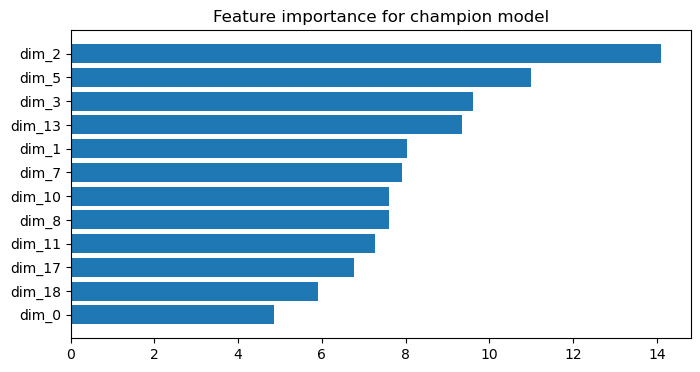

In [59]:
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::]
sorted_features = undropped_dimensions[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

plt.figure(figsize=(8, 4))
plt.barh(sorted_features, sorted_importance)
plt.title(f'Feature importance for champion model')
plt.show()
